In [157]:
%matplotlib inline

# Assignment 5

**DUE: Sunday July 24, 2021 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [158]:
NAME = "Erjie Zhang"
STUDENT_ID = "ezhang25"

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Question 1 Bitcoin price Prediction

Bitcoin, amongst other assets like AMC and GME, has been all the rage this past year and reached an all time high of \$63,729.5 per bitcoin. Since reaching it's high, the price has dropped by nearly a half. Analysts continue to feed the frenzy by releasing price predictions that range from from \$500,000 to \$9,000 per bitcoin in the next year. You will make an Recurrent neural network model to gain some insight into price prediction. Yahoo! Finance is a trusted name in free financial information and has been with us since the internet's early years. You'll be using data gathered obtained from https://finance.yahoo.com/quote/BTC-USD/history/ to train your recurrent neural network.

Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

In [160]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1JbrxeSqazKn-WjizVDPG9VvhkXVG--D-'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [161]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [162]:
# Plot data.head()
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. First, we will make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

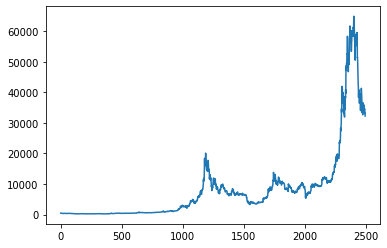

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2495,2495), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

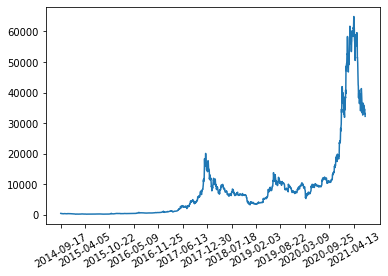

In [164]:

import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2495,2495), y = data['High'].values.reshape(-1))
#g.map(plt.plot, "a", "v", marker="o")
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### Part a) Data preprocessing (5 points)

In this section you will preprocess the in order to train a recurrent neural network. We can see that there 5 columns, "Date", "Open", "High", "Low", "Close", "Adjusted Close", and "Volume". We will only use the High column.

In [165]:
# Create a dataframe that only contains High Column.
# Hint: it may be helpful to now cast your pruned dataframe to a numpy array.

import numpy

#Drop all NaN row
filtered_data = data[data['High'].notna()]
data_high = filtered_data[['High']]

data_high =numpy.array(data_high)

data_len = len(data_high)



Recall [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from sklearn. Use it to scale the data for our analysis. 

In [166]:
### YOUR CODE HERE ###
from sklearn.preprocessing import MinMaxScaler

# Get the max and min for scaler
scaler = MinMaxScaler()

data_normalized = scaler.fit_transform(data_high)

data_normalized


array([[0.003967],
       [0.003792],
       [0.003343],
       ...,
       [0.508105],
       [0.509624],
       [0.495066]])

You will implement a simple autoregressive recurrent neural network using the standard tensorflow RNN architectures. An autoregressive model originates from the literature on time-series models where observations from the previous time-steps are used to predict the value at the current time step. To implemement an autoregressive model, we will simply augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction. The function to augment the data is given to you:

In [167]:

def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [168]:
# Choose the number of time steps that the model "looks back"
time_steps = 10 ### YOUR CODE HERE ###

# Produce your dataset based on the number of days the model could look back

### YOUR CODE HERE ###
X, y = create_dataset(data_normalized, time_steps)

X = numpy.reshape(X, (2491-time_steps-1, time_steps))
y = numpy.reshape(y, (2491-time_steps-1, ))


In [169]:
# Check the shape of your dataset; should be (2495-time_steps-1, time_steps) and (2495-time_steps-1,)
print(X.shape, y.shape)

(2480, 10) (2480,)


### Part b) Data Partitioning (5 points)

Split data into train and test sets. Use 80\% for training and 20\% for testing. **Note**: you need to split the data in time (the begining 80\% of the days from start date will be the training data and the remaining 20\% will be test data).

In [170]:
### YOUR CODE HERE ###
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=144)

For this dataset, you need to reshape the partitions for the model to be able to process them.

In [171]:
# Reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_train.shape

(1984, 1, 10)

### Part c) RNN Model (20 points)
---

In this part you will create a model using an RNN layer (LSTM or GRU, unidirectional or bidirectional) and train it on your training data. You will also plot training and validation loss. Use mean squared error as your model's metric.

Compile your model and display the summary:

In [172]:
# Build your model

### YOUR CODE HERE ###

from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM
from tensorflow.keras.models import Model

input_shape = (1, time_steps)
vocab_size = 1000

input_layer = Input(shape=(input_shape))
#x = Embedding(input_dim=vocab_size, output_dim=64)(input_layer)

x = LSTM(64)(input_layer) 

x = Dense(64, activation='relu')(x)
#x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
#x = Dropout(0.8)(x)

x = Dense(1, activation='sigmoid')(x)
sentiment_model = Model(input_layer, x)

sentiment_model.summary()

loss = tf.keras.losses.BinaryCrossentropy() ### YOUR CODE HERE ###

opt = tf.keras.optimizers.Adam(2e-4) ### YOUR CODE HERE ###

metrics = tf.keras.metrics.MeanSquaredError() ### YOUR CODE HERE ###

sentiment_model.compile(loss=loss,
                        optimizer=opt,
                        metrics=metrics)



Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1, 10)]           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                19200     
_________________________________________________________________
dense_51 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_52 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 33        
Total params: 25,473
Trainable params: 25,473
Non-trainable params: 0
_________________________________________________________________


In [173]:

batchsize = 256 ### YOUR CODE HERE ###

epochs =  20 ### YOUR CODE HERE ###

y_train.shape
# Fit model
history = sentiment_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batchsize, epochs=epochs)### YOUR CODE HERE ###


Epoch 1/20
8/8 [==============================] - 3s 85ms/step - loss: 0.6929 - mean_squared_error: 0.1774 - val_loss: 0.6911 - val_mean_squared_error: 0.1758
Epoch 2/20
8/8 [==============================] - 0s 9ms/step - loss: 0.6895 - mean_squared_error: 0.1757 - val_loss: 0.6877 - val_mean_squared_error: 0.1741
Epoch 3/20
8/8 [==============================] - 0s 12ms/step - loss: 0.6861 - mean_squared_error: 0.1740 - val_loss: 0.6841 - val_mean_squared_error: 0.1722
Epoch 4/20
8/8 [==============================] - 0s 12ms/step - loss: 0.6825 - mean_squared_error: 0.1722 - val_loss: 0.6804 - val_mean_squared_error: 0.1704
Epoch 5/20
8/8 [==============================] - 0s 12ms/step - loss: 0.6787 - mean_squared_error: 0.1703 - val_loss: 0.6764 - val_mean_squared_error: 0.1684
Epoch 6/20
8/8 [==============================] - 0s 10ms/step - loss: 0.6745 - mean_squared_error: 0.1682 - val_loss: 0.6720 - val_mean_squared_error: 0.1662
Epoch 7/20
8/8 [==============================]

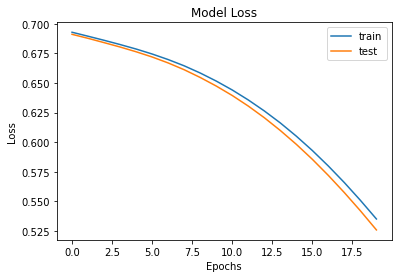

In [174]:
# Plot the Model loss

### YOUR CODE HERE ###
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part d) More Advanced RNN Model (20 points)
---
In this part you will create an RNN model with the number of layers and architerure you prefer. Train it on your training data. You will also plot training and validation loss. Again, use mean squared error as your metric. In this part, you can try different models and use different hyper-parameters and report only the best one.

Compile your model and display the summary:

In [175]:
# Build your model

input_shape = (1, time_steps)
vocab_size = 1000

input_layer = Input(shape=(input_shape))
#x = Embedding(input_dim=vocab_size, output_dim=64)(input_layer)

x = LSTM(64)(input_layer) 

x = Dense(64, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.4)(x)

x = Dense(1, activation='sigmoid')(x)
sentiment_model = Model(input_layer, x)

sentiment_model.summary()

loss = tf.keras.losses.BinaryCrossentropy() ### YOUR CODE HERE ###

opt = tf.keras.optimizers.Adam(2e-4) ### YOUR CODE HERE ###

metrics = tf.keras.metrics.MeanSquaredError() ### YOUR CODE HERE ###

sentiment_model.compile(loss=loss,
                        optimizer=opt,
                        metrics=metrics)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 1, 10)]           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                19200     
_________________________________________________________________
dense_54 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_38 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 32)                208

In [176]:
batchsize = 256 ### YOUR CODE HERE ###
epochs =  100### YOUR CODE HERE ###

# Fit model
history = sentiment_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batchsize, epochs=epochs)### YOUR CODE HERE ###

Epoch 1/100
8/8 [==============================] - 3s 89ms/step - loss: 0.6903 - mean_squared_error: 0.1761 - val_loss: 0.6857 - val_mean_squared_error: 0.1731
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.6829 - mean_squared_error: 0.1724 - val_loss: 0.6773 - val_mean_squared_error: 0.1689
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.6747 - mean_squared_error: 0.1683 - val_loss: 0.6674 - val_mean_squared_error: 0.1639
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.6650 - mean_squared_error: 0.1635 - val_loss: 0.6559 - val_mean_squared_error: 0.1581
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.6535 - mean_squared_error: 0.1577 - val_loss: 0.6428 - val_mean_squared_error: 0.1516
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 0.6404 - mean_squared_error: 0.1512 - val_loss: 0.6280 - val_mean_squared_error: 0.1443
Epoch 7/100
8/8 [=======================

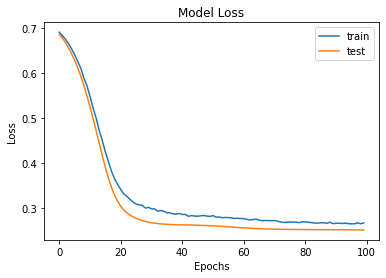

In [177]:
# Plot the Model loss

### YOUR CODE HERE ###
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part e): Looking at the Predictions (10 points)
---

Now, Using the final (best) model you trained, show your model's performance on the test set. Plot the model's prediction for Bitcoin Price along with the actual test set prices. Lastly, note how your model's predictions change with your model's architecture and the number of days you "look back". Does your model perform better with more "look back days" or less. Did adding more layers help? Does your model use dropout or batchnormalization?

**Note:** Your model is trained on normalized data. Inorder to transform your model's predictions to the original price range you will likely need to use sklearn's inverse_transform (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

[[8004.201172 7257.921875]
 [10907.630859 9396.040039]
 [7132.060547 6653.299805]
 [10867.701172 9680.367188]
 [530.600342 773.721985]
 [13716.270508 11377.599609]
 [613.747742 1008.840027]
 [538.399841 682.432007]
 [10067.646484 8414.227539]
 [463.863068 233.222000]
 [523.706360 626.830017]
 [10883.789062 9401.107422]
 [11488.088867 10074.238281]
 [2839.077637 4376.390137]
 [10831.196289 9655.073242]
 [6701.009277 6463.549805]
 [520.114868 599.500000]
 [2112.929443 3620.746582]
 [9169.779297 8710.636719]
 [10368.265625 9412.089844]
 [2154.010010 3743.387939]
 [6496.508789 6378.135254]
 [497.045746 467.964996]
 [2384.084473 3926.597656]
 [486.521790 384.037994]
 [13706.761719 14028.213867]
 [4863.827637 5522.262695]
 [7775.962891 6958.557129]
 [45760.769531 48875.570313]
 [481.697174 429.717987]
 [8226.674805 7781.867188]
 [6805.765625 6556.379883]
 [493.951385 429.273987]
 [489.787628 397.765991]
 [468.689606 237.408997]
 [49878.343750 57996.621094]
 [491.768341 394.542999]
 [537.0510

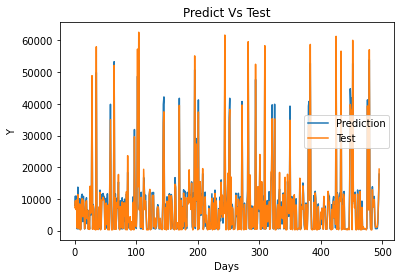

In [178]:
### YOUR CODE HERE ###
from sklearn.preprocessing import StandardScaler

# Fit the model
y_pred =  sentiment_model.predict(X_test)

# Do inverse_transform
y_origin_pred = scaler.inverse_transform(y_pred)
y_origin_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Print predictions with actual test results
np.set_printoptions(formatter={'float_kind':'{:f}'.format},precision=2)
print(np.concatenate((y_origin_pred.reshape(len(y_origin_pred),1), y_origin_test.reshape(len(y_origin_test),1)),1))

# Plot the graph
plt.plot(y_origin_pred)
plt.plot(y_origin_test)
plt.title('Predict Vs Test')
plt.ylabel('Y')
plt.xlabel('Days')
plt.legend(['Prediction', 'Test'])
plt.show()

First, it is interesting that looking back for more days (for example, time_steps = 100) **does not** neccessaily reduce the loss. I didn't try all options but I just set the time_steps = 10.

Also, I add more Dense layers and drop layers, and they actually help the model.
The plot is a little bit unclear, so I print out the prediction array and test array. We can see how close the prices are.

## Question 3: Denoising Autoencoder


You will now build a simple denoising autoencoder using the MNIST Fashion dataset. Begin by getting our imports and downloading the dataset.

In [181]:
import os
import numpy as np
from keras.datasets import fashion_mnist

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn
rn.seed(123)
np.random.seed(seed=123)

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
%matplotlib inline

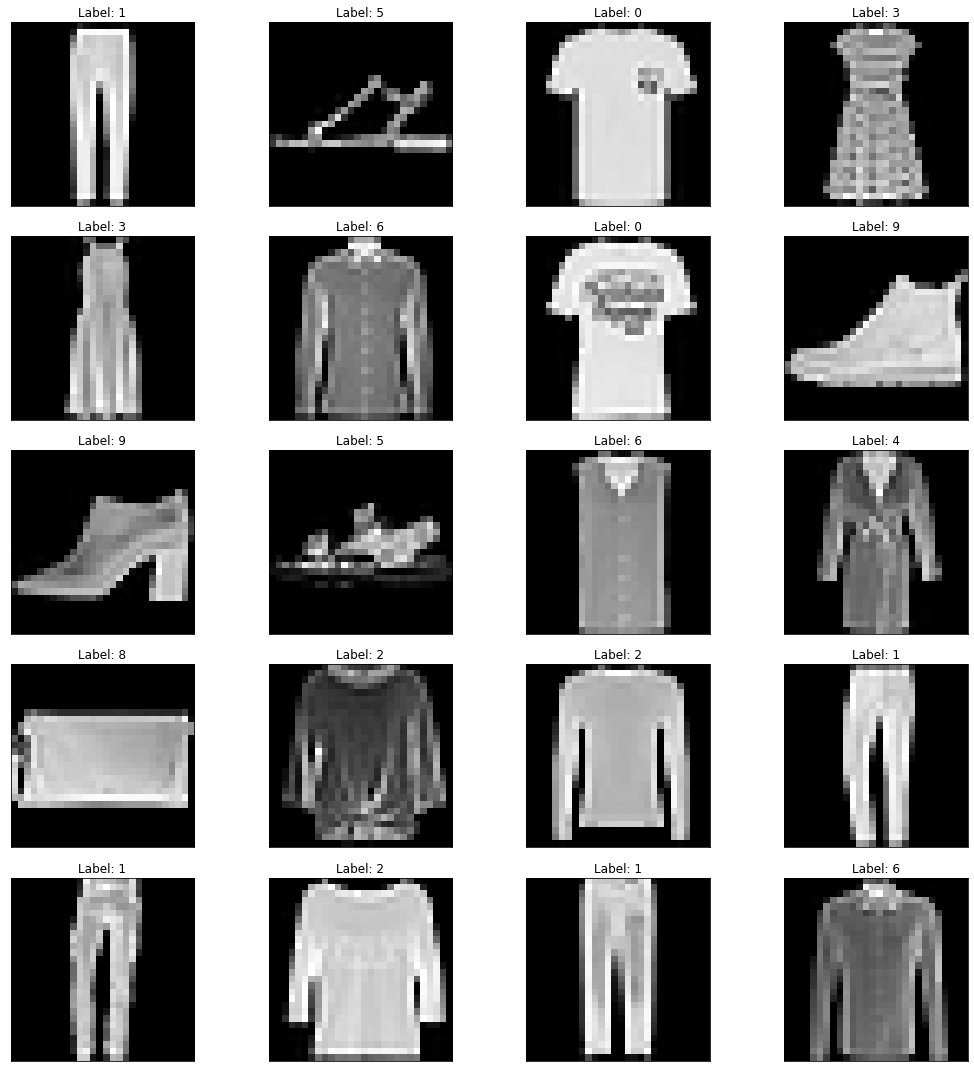

In [182]:
# Plot some of the images from x_test
fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(4):
        l=rn.randint(0, len(y_test))
        ax[i, j].imshow(x_test[l], cmap='gray')
        ax[i, j].set_title('Label: ' + str(y_test[l]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
plt.tight_layout()

As expected, we have the MNIST Fashion dataset. Now, noise will be added to the images in boath x_train and x_test. Then, we will plot some of the noisy images from x_train. This may take a little while.

In [183]:
def corrupt_pixel(image):
    """selects a certain number of pixels (between 50 and 100) and changes their value to 255"""
    num_pixels = np.random.randint(50,100)
    img = image.copy()

    for i in range(num_pixels):
        cell = np.random.randint(0,28,size = 2)
        img[cell[0]][cell[1]] = np.random.randint(125,255)
    return img

In [184]:
# corrupt the images
x_train_noisy = [] #x_train with noise added
for image in x_train:
    x_train_noisy.append(corrupt_pixel(image))

x_test_noisy = [] #x_test with noise added
for image in x_test:
    x_test_noisy.append(corrupt_pixel(image))

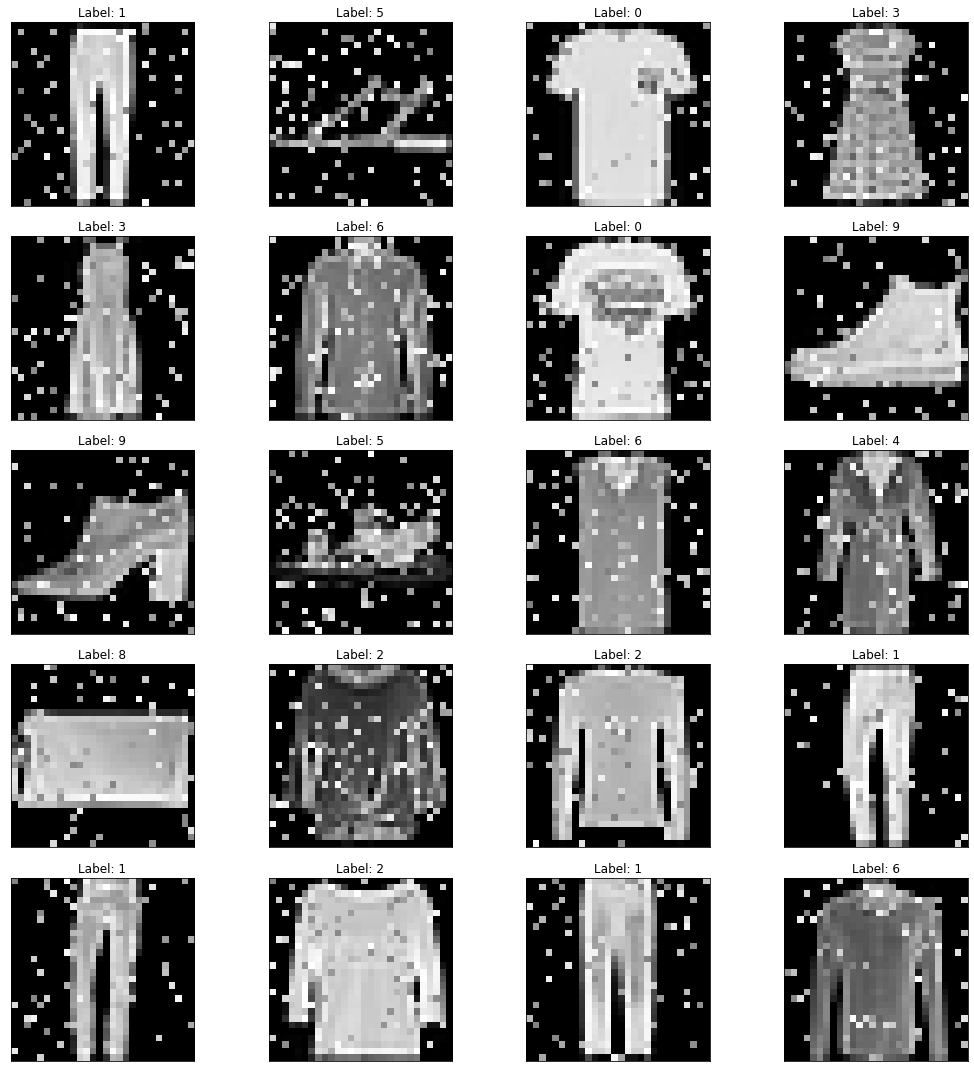

In [185]:
# Replot some of the test images with noise added
rn.seed(123)
np.random.seed(seed=123)

fig, ax = plt.subplots(5, 4)
fig.set_size_inches(15, 15)

for i in range(5):
    for j in range(4):
        l=rn.randint(0, len(y_test))
        ax[i, j].imshow(x_test_noisy[l], cmap='gray')
        ax[i, j].set_title('Label: ' + str(y_test[l]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
plt.tight_layout()

We can now see that we have corrupted the images. We will now build a denoising autoencoder to hopefully remove some of the noise. First, data will be normalize the data and an extra dimension will be added to the images.

In [186]:
# Scale X_train to 255. which is max
x_train  = np.array(x_train)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_train = x_train.reshape(len(x_train),28,28,1)

# Scale X_test to 255. which is max
x_test  = np.array(x_test)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_test = x_test.reshape(len(x_test),28,28,1)

# Scale X_train to 255. which is max
x_train_noisy  = np.array(x_train_noisy)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_train_noisy = x_train_noisy.reshape(len(x_train_noisy),28,28,1)

# Scale X_test to 255. which is max
x_test_noisy  = np.array(x_test_noisy)/255.

# Reshape X_train to (N,28,28,1) for convolution layers
x_test_noisy = x_test_noisy.reshape(len(x_test_noisy),28,28,1)

### Part a) Build the autoencoder (20 points)


 Now we will build the autoencoder. You are free to build an architecture of your choice. Again, You are welcome to use any code from previous class exercises, section handouts, and lectures. Build your model below and comment on your model's architecture. Do you have convolution layers, or a fully connected encoder, dropout and/or batch normalization, what kind of activation did you use? It may help to think about the encoder/decoder architectures simultaneously.

You may use the TensorFlow documentation freely. You might also find online tutorials helpful. However, all code that you submit must be your own.


In [193]:
# Build your model

### YOUR CODE HERE ###
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras import backend

loss='mse'
optimizer='adam'

image_size = x_train.shape[1]

input_shape = (image_size, image_size, 1)
batch = 256
kernel = 3
latent_dim = 16

## Encoder ##
# Number of filters in each layer
layer_filters = [32, 64]

inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

# Conv2D layers
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel,
               strides=2,
               activation='relu',
               padding='same')(x)

# Decoder Model will need the shape information
shape = backend.int_shape(x)

# Latent vector (with some dropout)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dropout(0.7)(x)

latent = Dense(latent_dim, name='latent_vector')(x)

# Build Encoder Model
encoder = Model(inputs, latent, name='Encoder')
encoder.summary()

## Decoder ##
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# Adding Transposed Conv2D layers
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

# Check the decoder summary
decoder = Model(latent_inputs, outputs, name='Decoder')
decoder.summary()

# Build Autoencoder

AE = Model(inputs, decoder(encoder(inputs)), name='Autoencoder')
AE.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_25 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_______________________________________________________

I use the code from class exercise as a template.

I have some convolution layers add some dropout layers. (Adding drop out layers does help the resul)

I changed some other hyperparameters. It took a long time to fit even with epoch=10. Also, I increased the batch size to 256.

### Part b) Training the autoencoder (10 points)
Write code that trains your autoencoder. Use mean square error as your loss, choose an optimizer of your choice. Be

Plot the training curve as well.

In [194]:
# Compile your model

### YOUR CODE HERE ###
AE.compile(loss=loss, 
           optimizer=optimizer)

# Train the autoencoder

### YOUR CODE HERE ###
history = AE.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=10,
                batch_size=batch)

Epoch 1/10
235/235 [==============================] - 91s 383ms/step - loss: 0.0567 - val_loss: 0.0248
Epoch 2/10
235/235 [==============================] - 90s 382ms/step - loss: 0.0233 - val_loss: 0.0187
Epoch 3/10
235/235 [==============================] - 90s 382ms/step - loss: 0.0196 - val_loss: 0.0163
Epoch 4/10
235/235 [==============================] - 90s 383ms/step - loss: 0.0181 - val_loss: 0.0153
Epoch 5/10
235/235 [==============================] - 90s 382ms/step - loss: 0.0173 - val_loss: 0.0146
Epoch 6/10
235/235 [==============================] - 90s 381ms/step - loss: 0.0168 - val_loss: 0.0142
Epoch 7/10
235/235 [==============================] - 89s 381ms/step - loss: 0.0165 - val_loss: 0.0138
Epoch 8/10
235/235 [==============================] - 90s 385ms/step - loss: 0.0162 - val_loss: 0.0137
Epoch 9/10
235/235 [==============================] - 93s 395ms/step - loss: 0.0160 - val_loss: 0.0134
Epoch 10/10
235/235 [==============================] - 92s 390ms/step - l

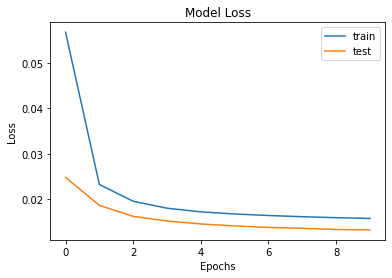

In [195]:
# Plot the training curve for loss

### YOUR CODE HERE ###
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part c) Plot images and comment (10 points)

Plot images some of the "denoised" images from the test set. Comment on how your model has performed. Was your model able to denoise the image successfully? Is there anything unexpected results about the images? MSE error is known to smooth an image too much, did your model suffere the same result?

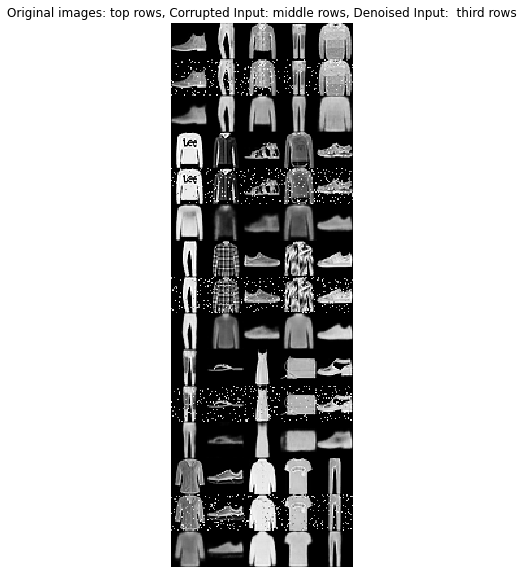

In [196]:
# Plot images some of the "denoised" images from the test set

### YOUR CODE HERE ###
# Get the prediction from Autoencoder
x_decoded = AE.predict(x_test_noisy)

# Display the result (using code from exercise as template)
rows, cols = 5, 5
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.show()

In general it does work successfully because I don't see noise on the image after fitting. However, it does have error of over-smoothening. At the beginning the problem was huge.I tried to do optimization and it should look better now.